# Part 4: Sentiment of the artists and communities

* Calculate the sentiment of the band/artist pages (it is OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.
* Discuss the sentiment of the communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?

###  Exercise 1: Sentiment distribution.

Saved LabMT to labMT.txt
✅ Loaded LabMT with 10,222 words
✅ Computed sentiment for 482 of 482 pages

Summary Statistics
------------------
        n: 482
     mean: 6.2390
   median: 6.2578
 variance: 0.0262
      p25: 6.1739
      p75: 6.3360


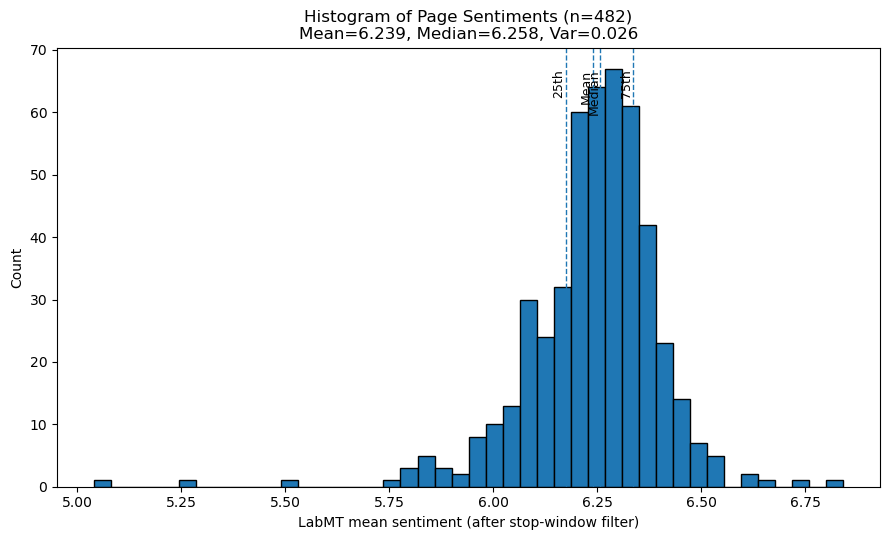


10 Saddest Pages (lowest sentiment):
------------------------------------
 1. iron maiden                              | 5.0415
 2. firehouse                                | 5.2725
 3. cold chisel                              | 5.5275
 4. crash test dummies                       | 5.7489
 5. quiet riot                               | 5.7843
 6. five finger death punch                  | 5.8047
 7. marilyn manson                           | 5.8102
 8. white zombie (band)                      | 5.8222
 9. traffic (band)                           | 5.8314
10. ted nugent                               | 5.8495

10 Happiest Pages (highest sentiment):
--------------------------------------
 1. great white                              | 6.8399
 2. the boxtones                             | 6.7291
 3. air supply                               | 6.6657
 4. lenny kravitz                            | 6.6007
 5. michael martin murphey                   | 6.5992
 6. fun (band)                      

In [1]:
"""
Steps:
1. Download and clean LabMT wordlist (Data Set S1) -> labMT.txt
2. Load LabMT; define tokenization + sentiment function
3. Compute sentiment for each node in the network JSON
4. Compute average, median, variance, 25th and 75th percentiles
5. Plot histogram
6. Print the 10 happiest and 10 saddest artists
"""

# ======================
# Configuration
# ======================
LABMT_URL = "https://doi.org/10.1371/journal.pone.0026752.s001"
LABMT_TXT = "labMT.txt"
INPUT_GRAPH_JSON = "rockstar_graph_with_text.json"

NEUTRAL_CENTER = 5.0
STOP_WINDOW = 1.0   # ± around 5.0

# ======================
# Imports
# ======================
import os, json, re, math
from statistics import mean
from typing import Dict, Iterable, List, Tuple, Optional
import numpy as np
import matplotlib.pyplot as plt

# Make sure plots show inline
%matplotlib inline

# ======================
# Q1 – Download LabMT
# ======================
def download_labmt(url: str = LABMT_URL, out_path: str = LABMT_TXT):
    """Download LabMT wordlist (Data Set S1) and strip first 3 header lines."""
    import requests
    print(f"Downloading LabMT from {url} ...")
    r = requests.get(url)
    if r.status_code != 200:
        raise RuntimeError(f"Download failed with status {r.status_code}")
    lines = r.text.splitlines()[3:]
    with open(out_path, "w", encoding="utf-8") as f:
        f.write("\n".join(lines))
    print(f"Saved LabMT to {out_path}")

if not os.path.exists(LABMT_TXT):
    try:
        download_labmt()
    except Exception as e:
        print(f"⚠️ Could not download LabMT automatically: {e}")
else:
    print("✅ LabMT file already exists")

# ======================
# Q2 – Load + sentiment function
# ======================
def load_labmt(filepath: str = LABMT_TXT) -> Dict[str, float]:
    lex = {}
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) >= 3:
                try:
                    lex[parts[0].lower()] = float(parts[2])
                except ValueError:
                    continue
    if not lex:
        raise RuntimeError("LabMT list empty or formatted incorrectly.")
    return lex

_WORD_RE = re.compile(r"[a-z']+")

def tokenize(text: str) -> List[str]:
    return _WORD_RE.findall(text.lower()) if text else []

def labmt_sentiment_from_tokens(tokens: Iterable[str], labmt: Dict[str, float],
                                stop_window: float = STOP_WINDOW,
                                neutral_center: float = NEUTRAL_CENTER) -> Tuple[Optional[float], int]:
    """Mean happiness ignoring near-neutral words."""
    if not tokens:
        return None, 0
    low, high = neutral_center - stop_window, neutral_center + stop_window
    scores = [s for t in tokens if (s := labmt.get(t)) is not None and (s < low or s > high)]
    return (mean(scores), len(scores)) if scores else (None, 0)

labmt = load_labmt()
print(f"✅ Loaded LabMT with {len(labmt):,} words")

# ======================
# Q3 – Attach sentiment to nodes
# ======================
with open(INPUT_GRAPH_JSON, "r", encoding="utf-8") as f:
    graph = json.load(f)

nodes = graph.get("nodes", [])
if not nodes:
    raise RuntimeError("No nodes found in network JSON.")

# detect text field
text_field = next((k for k in ["clean_text","text","content","body"] if k in nodes[0]), None)
if not text_field:
    raise RuntimeError("No text field found in nodes.")

id_sent = []
for n in nodes:
    toks = tokenize(n.get(text_field, "") or "")
    s, matched = labmt_sentiment_from_tokens(toks, labmt, STOP_WINDOW)
    n["labmt_sent_mean"], n["labmt_n_matched"], n["token_count"] = s, matched, len(toks)
    if s is not None:
        id_sent.append((n.get("id", ""), float(s)))

print(f"✅ Computed sentiment for {len(id_sent)} of {len(nodes)} pages")

# ======================
# Q4 – Summary stats
# ======================
arr = np.array([s for _, s in id_sent], dtype=float)
stats = {
    "n": arr.size,
    "mean": float(np.mean(arr)),
    "median": float(np.median(arr)),
    "variance": float(np.var(arr)),
    "p25": float(np.percentile(arr, 25)),
    "p75": float(np.percentile(arr, 75)),
}
print("\nSummary Statistics")
print("------------------")
for k, v in stats.items():
    print(f"{k:>9}: {v:.4f}" if isinstance(v, float) else f"{k:>9}: {v}")

# ======================
# Q5 – Histogram (inline)
# ======================
def fd_bins(x: np.ndarray) -> int:
    n = x.size
    q75, q25 = np.percentile(x, [75, 25])
    iqr = q75 - q25
    if iqr <= 0:
        return max(5, int(np.sqrt(n)))
    bw = 2 * iqr / (n ** (1/3))
    return max(5, int(math.ceil((x.max() - x.min()) / bw)))

bins = fd_bins(arr)

plt.figure(figsize=(9, 5.5))
plt.hist(arr, bins=bins, edgecolor="black")

# reference lines
for val, lbl in [(stats["mean"],"Mean"),(stats["median"],"Median"),
                 (stats["p25"],"25th"),(stats["p75"],"75th")]:
    plt.axvline(val, linestyle="--", linewidth=1)
    ylim = plt.gca().get_ylim()
    plt.text(val, ylim[1]*0.95, lbl, rotation=90, va="top", ha="right", fontsize=9)

plt.title(f"Histogram of Page Sentiments (n={stats['n']})\n"
          f"Mean={stats['mean']:.3f}, Median={stats['median']:.3f}, Var={stats['variance']:.3f}")
plt.xlabel("LabMT mean sentiment (after stop-window filter)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ======================
# Q6 – Print happiest & saddest
# ======================
id_sent.sort(key=lambda x: x[1])
bottom, top = id_sent[:10], id_sent[-10:][::-1]

print("\n10 Saddest Pages (lowest sentiment):")
print("------------------------------------")
for i, (aid, s) in enumerate(bottom, 1):
    print(f"{i:2d}. {aid:40s} | {s:.4f}")

print("\n10 Happiest Pages (highest sentiment):")
print("--------------------------------------")
for i, (aid, s) in enumerate(top, 1):
    print(f"{i:2d}. {aid:40s} | {s:.4f}")

print("\n✅ Done.")


###  Exercise 2: Community sentiment distribution.

Using 4 communities (largest) out of the detected set.

Community-level sentiment (largest communities)
------------------------------------------------
[C01] size= 167  n_sents= 167  mean=6.268  median=6.265  Q1=6.197  Q3=6.338  name: the beatles, the rolling stones, bob dylan
[C02] size= 136  n_sents= 136  mean=6.268  median=6.281  Q1=6.201  Q3=6.341  name: green day, u2, david bowie
[C03] size= 105  n_sents= 105  mean=6.182  median=6.227  Q1=6.073  Q3=6.311  name: metallica, alice in chains, led zeppelin
[C04] size=  74  n_sents=  74  mean=6.201  median=6.223  Q1=6.124  Q3=6.324  name: deep purple, def leppard, queen (band)

Saddest communities:
--------------------
• C03 (metallica, alice in chains, led zeppelin)  mean=6.182  n=105
• C04 (deep purple, def leppard, queen (band))  mean=6.201  n=74

Happiest communities:
---------------------
• C01 (the beatles, the rolling stones, bob dylan)  mean=6.268  n=167
• C02 (green day, u2, david bowie)  mean=6.268  n=136


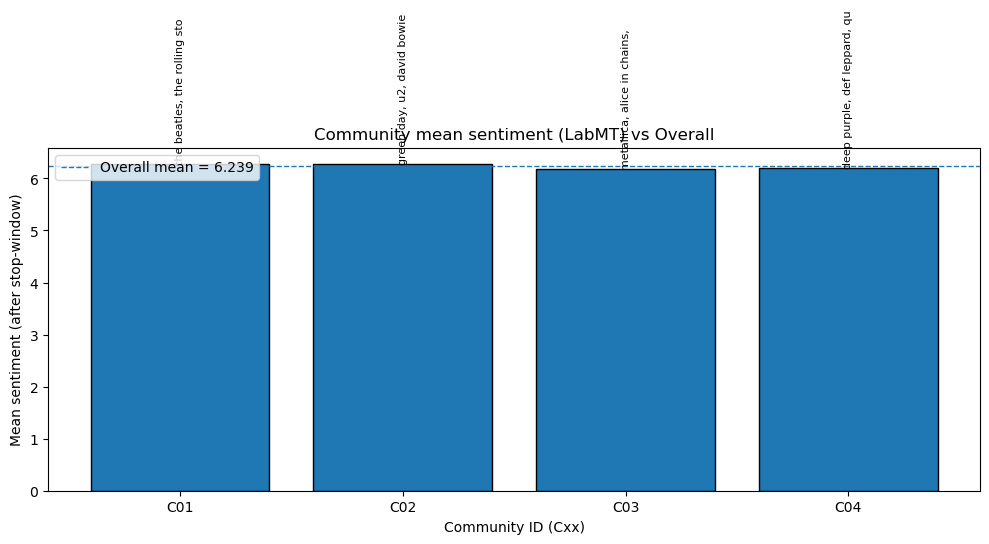


Comparison to overall:
----------------------
C01 (the beatles, the rolling stones, bob dylan): mean 6.268 is 0.029 higher than overall.
C02 (green day, u2, david bowie): mean 6.268 is 0.029 higher than overall.
C03 (metallica, alice in chains, led zeppelin): mean 6.182 is 0.057 lower than overall.
C04 (deep purple, def leppard, queen (band)): mean 6.201 is 0.038 lower than overall.


In [2]:
# ============ Exercise 2: Community sentiment distribution ============

# Input: louvain_communities.json  ->  list[list[str]] (each inner list is the node ids in that community)

import json
import math
import numpy as np
import matplotlib.pyplot as plt

COMMUNITIES_PATH = "louvain_communities.json"
TOP_K_COMMUNITIES = 10  # largest K communities (or all if fewer)

# --- 0) Helpers over the raw JSON graph (no NetworkX needed) ---

# Build quick lookup tables from Exercise 1's `graph`
nodes_list = graph["nodes"]
links_list = graph["links"]  # assumed undirected; if directed, we still treat as undirected here

id_to_node = {n["id"]: n for n in nodes_list}
all_ids = set(id_to_node.keys())

def node_sent(node_id):
    """Return labmt_sent_mean (float) or None if missing."""
    n = id_to_node.get(node_id)
    if not n:
        return None
    return n.get("labmt_sent_mean")

def internal_degrees(members_set):
    """
    Compute internal degree (within the community) for each member
    using graph['links'] as undirected edges.
    Returns dict {node_id: degree_in_subgraph}.
    """
    deg = {nid: 0 for nid in members_set}
    for e in links_list:
        u = e.get("source")
        v = e.get("target")
        if u in members_set and v in members_set:
            deg[u] += 1
            deg[v] += 1
    return deg

def top3_names_by_internal_degree(members):
    if not members:
        return []
    mset = set(members)
    deg = internal_degrees(mset)
    # Sort by degree desc, then by name for stability
    top3 = sorted(deg.items(), key=lambda kv: (-kv[1], kv[0]))[:3]
    return [nid for nid, d in top3]

# --- 1) Load communities and keep the 10 largest (or all if fewer) ---
with open(COMMUNITIES_PATH, "r", encoding="utf-8") as f:
    communities_raw = json.load(f)

# Filter to node ids that actually exist in this graph
communities = []
for members in communities_raw:
    present = [nid for nid in members if nid in all_ids]
    if present:
        communities.append(present)

# Sort by size desc and keep top K
communities.sort(key=len, reverse=True)
if len(communities) > TOP_K_COMMUNITIES:
    communities = communities[:TOP_K_COMMUNITIES]

print(f"Using {len(communities)} communities (largest) out of the detected set.")

# --- 2) Compute overall mean sentiment for reference ---
overall_vals = [node_sent(nid) for nid in all_ids]
overall_vals = [x for x in overall_vals if x is not None and not math.isnan(x)]
overall_mean = float(np.mean(overall_vals)) if overall_vals else float("nan")

# --- 3) Compute stats per community + names from top-3 internal hubs ---
results = []
for cid, members in enumerate(communities, start=1):
    vals = [node_sent(nid) for nid in members]
    vals = [x for x in vals if x is not None and not math.isnan(x)]
    arr = np.array(vals, dtype=float) if vals else np.array([], dtype=float)

    if arr.size > 0:
        stats = {
            "mean": float(np.mean(arr)),
            "median": float(np.median(arr)),
            "variance": float(np.var(arr)),
            "p25": float(np.percentile(arr, 25)),
            "p75": float(np.percentile(arr, 75)),
            "n_with_sentiment": int(arr.size),
        }
    else:
        stats = {"mean": np.nan, "median": np.nan, "variance": np.nan,
                 "p25": np.nan, "p75": np.nan, "n_with_sentiment": 0}

    name_top3 = top3_names_by_internal_degree(members)

    results.append({
        "cid": cid,
        "size": len(members),
        "name_top3": name_top3,
        **stats
    })

# --- 4) Print a compact table ---
print("\nCommunity-level sentiment (largest communities)")
print("------------------------------------------------")
for r in results:
    label = ", ".join(r["name_top3"]) if r["name_top3"] else f"Community {r['cid']}"
    mean_s = f"{r['mean']:.3f}" if not np.isnan(r["mean"]) else "nan"
    med_s  = f"{r['median']:.3f}" if not np.isnan(r["median"]) else "nan"
    p25_s  = f"{r['p25']:.3f}" if not np.isnan(r["p25"]) else "nan"
    p75_s  = f"{r['p75']:.3f}" if not np.isnan(r["p75"]) else "nan"
    print(
        f"[C{r['cid']:02d}] size={r['size']:4d}  n_sents={r['n_with_sentiment']:4d}  "
        f"mean={mean_s}  median={med_s}  Q1={p25_s}  Q3={p75_s}  "
        f"name: {label}"
    )

# --- 5) Happiest & saddest communities ---
valid = [r for r in results if not np.isnan(r["mean"])]
valid.sort(key=lambda x: x["mean"])

k = 2 if len(valid) <= 5 else 3
saddest = valid[:k]
happiest = valid[-k:][::-1]

def fmt_comm(r):
    nm = ", ".join(r["name_top3"])
    return f"C{r['cid']:02d} ({nm})  mean={r['mean']:.3f}  n={r['n_with_sentiment']}"

print("\nSaddest communities:")
print("--------------------")
for r in saddest:
    print("•", fmt_comm(r))

print("\nHappiest communities:")
print("---------------------")
for r in happiest:
    print("•", fmt_comm(r))

# --- 6) Bar chart vs overall mean ---
labels = [f"C{r['cid']:02d}" for r in results]
means = [r["mean"] for r in results]

plt.figure(figsize=(10, 5.5))
bars = plt.bar(labels, means, edgecolor="black")

# annotate bars with top-3 names
for rect, r in zip(bars, results):
    height = rect.get_height()
    if not np.isnan(height):
        nm = ", ".join(r["name_top3"])[:28]
        plt.text(rect.get_x() + rect.get_width()/2.0, height, nm,
                 ha="center", va="bottom", fontsize=8, rotation=90)

plt.axhline(overall_mean, linestyle="--", linewidth=1,
            label=f"Overall mean = {overall_mean:.3f}" if not np.isnan(overall_mean) else "Overall mean = nan")

plt.title("Community mean sentiment (LabMT) vs Overall")
plt.ylabel("Mean sentiment (after stop-window)")
plt.xlabel("Community ID (Cxx)")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

# --- 7) Brief textual comparison to overall ---
print("\nComparison to overall:")
print("----------------------")
for r in results:
    if np.isnan(r["mean"]) or np.isnan(overall_mean):
        continue
    delta = r["mean"] - overall_mean
    trend = "higher" if delta > 0 else "lower"
    print(f"C{r['cid']:02d} ({', '.join(r['name_top3'])}): "
          f"mean {r['mean']:.3f} is {abs(delta):.3f} {trend} than overall.")
